In [1]:
import audiofile

In [2]:
import numpy as np

In [3]:
import matplotlib.pyplot as plt

In [4]:
import matplotlib.lines as plt_lines

In [5]:
from scipy.signal import hilbert, savgol_filter

In [6]:
from scipy.interpolate import Akima1DInterpolator

In [7]:
from sklearn.preprocessing import minmax_scale

In [8]:
AUDIO_FILE = 'noisy'

In [9]:
from scipy.signal import spectrogram

In [10]:
def hilbert_transform(data, fs, w=1024):
    s = hilbert(data)
    ampl = np.abs(s)
    phi = np.unwrap(np.angle(s))
    f = (np.diff(phi) / (2.0*np.pi) * fs)

    mSA = []
    for x in range(0, s.size-w, w):
        mSA.append(np.sqrt(np.mean(s[x:x+w]) ** 2))

    mf = []
    for x in range(0, f.size-w, w):
        mf.append(np.sqrt(np.mean(f[x:x+w]) ** 2))

    mf = np.array(mf)
    mf_smoothed = 1-savgol_filter(mf, 8, 1)
    
    return (s, f, phi, ampl, np.array(mSA), mf, mf_smoothed)

In [11]:
def variance_spectral_entropy(data, fs, N=512, wsV=32):
    f, t, Sxx = spectrogram(x=data, fs=fs, nfft=N)
    h = []
    p = []
    v = []
    for i in range(t.size-1):
        M = Sxx[:, i]
        P = M / np.sum(M)
        P += 0.000000001
        H = -np.sum(P * np.log2(P))
        H = H / np.log2(N)
        h.append(H)
        p.append(P)

    for x in range(0, len(h)-wsV, wsV):
        v.append(np.var(h[x:x+wsV]))

    h_smoothed = 1-savgol_filter(np.array(h), N, 2)
    
    deriv = []
    for x in range(0, h_smoothed.size-2):
        deriv.append(np.abs(h_smoothed[x]-h_smoothed[x+1]))
    deriv.append(0.)
    deriv = 1-savgol_filter(np.array(deriv), 8, 1)
    deriv = minmax_scale(deriv, (0., 1.))

    return (np.block(h), np.array(v), np.block(p), h_smoothed, deriv)

In [12]:
signal, fs = audiofile.read(f'{AUDIO_FILE}.wav')
if signal.ndim == 2 and signal.shape[0] == 2:
    signal = signal[0]

In [13]:
v = variance_spectral_entropy(data=signal, fs=fs)

In [14]:
h = hilbert_transform(data=signal, fs=fs)

In [15]:
mult_d = minmax_scale(np.interp(np.linspace(0, v[4].size-1, num=signal.size), np.arange(v[4].size), v[4]))
mult_vs = minmax_scale(1-np.interp(np.linspace(0, v[3].size-1, num=signal.size), np.arange(v[3].size), v[3]))
mult_h = minmax_scale(1-np.interp(np.linspace(0, h[6].size-1, num=signal.size), np.arange(h[6].size), h[6]))

mult = mult_d * mult_vs * mult_h

In [16]:
sig_new = signal * mult
audiofile.write(f'{AUDIO_FILE}-processed.wav', sig_new, fs, bit_depth=24, normalize=True)

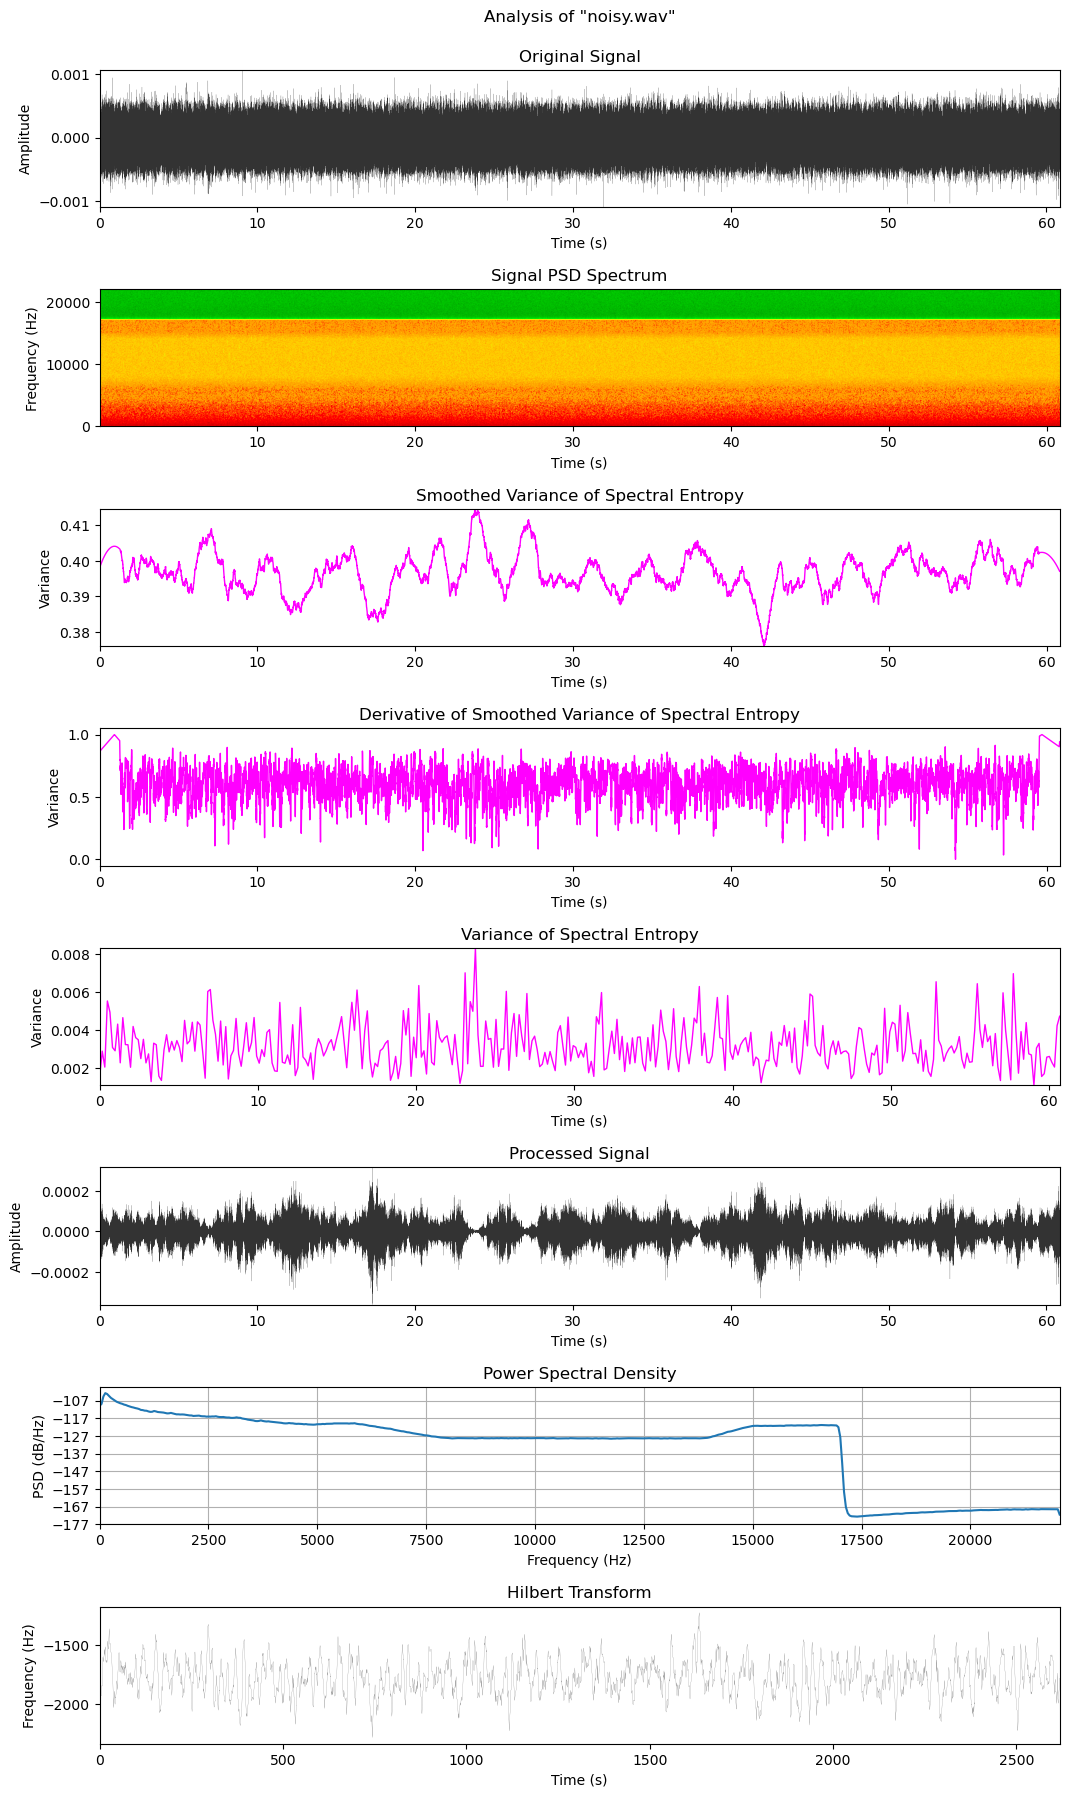

In [17]:
f = plt.figure()
f.subplots_adjust(left=0.1, right=0.9, top=2.9, hspace=0.6)
f.set_figheight(6)
f.set_figwidth(12)
plt.suptitle(f'Analysis of "{AUDIO_FILE}.wav"', y=3.)

T = np.linspace(0, signal.size / fs, signal.size, endpoint=False)
ax_sig = f.add_subplot(811)
ax_sig.margins(x=0)
ax_sig.set_ylim(bottom=np.min(signal), top=np.max(signal))
ax_sig.set_title('Original Signal')
ax_sig.set_ylabel('Amplitude')
ax_sig.set_xlabel('Time (s)')
ax_sig.plot(T, signal, color='#333333', linewidth=.1)

ax_psd_spec = f.add_subplot(812)
ax_psd_spec.margins(x=0)
ax_psd_spec.set_title('Signal PSD Spectrum')
ax_psd_spec.set_ylabel('Frequency (Hz)')
ax_psd_spec.set_xlabel('Time (s)')
ax_psd_spec.specgram(signal, NFFT=1024, Fs=fs, window=np.bartlett(1024), noverlap=900, mode='psd', cmap='nipy_spectral')

T = np.linspace(0, signal.size / fs, v[3].size, endpoint=False)
ax_se = f.add_subplot(813)
ax_se.margins(x=0)
ax_se.set_ylim(bottom=np.min(v[3]), top=np.max(v[3]))
ax_se.set_title('Smoothed Variance of Spectral Entropy')
ax_se.set_ylabel('Variance')
ax_se.set_xlabel('Time (s)')
ax_se.plot(T, v[3], color='magenta', linewidth=1)

T = np.linspace(0, signal.size / fs, v[4].size, endpoint=False)
ax_se = f.add_subplot(814)
ax_se.margins(x=0)
ax_se.set_title('Derivative of Smoothed Variance of Spectral Entropy')
ax_se.set_ylabel('Variance')
ax_se.set_xlabel('Time (s)')
ax_se.plot(T, v[4], color='magenta', linewidth=1)

T = np.linspace(0, signal.size / fs, v[1].size, endpoint=False)
ax_se = f.add_subplot(815)
ax_se.margins(x=0)
ax_se.set_ylim(bottom=np.min(v[1]), top=np.max(v[1]))
ax_se.set_title('Variance of Spectral Entropy')
ax_se.set_ylabel('Variance')
ax_se.set_xlabel('Time (s)')
ax_se.plot(T, v[1], color='magenta', linewidth=1)

T = np.linspace(0, sig_new.size / fs, sig_new.size, endpoint=False)
ax_sig_new = f.add_subplot(816)
ax_sig_new.margins(x=0)
ax_sig_new.set_ylim(bottom=np.min(sig_new), top=np.max(sig_new))
ax_sig_new.set_title('Processed Signal')
ax_sig_new.set_ylabel('Amplitude')
ax_sig_new.set_xlabel('Time (s)')
ax_sig_new.plot(T, sig_new, color='#333333', linewidth=.1)

ax_psd = f.add_subplot(817)
ax_psd.margins(x=0)
ax_psd.set_title('Power Spectral Density')
ax_psd.psd(signal, NFFT=1024, Fs=fs, noverlap=900)
ax_psd.set_ylabel('PSD (dB/Hz)')
ax_psd.set_xlabel('Frequency (Hz)')

xs = range(0, h[6].size)
ax_hilbert = f.add_subplot(818)
ax_hilbert.margins(x=0)
ax_hilbert.set_title('Hilbert Transform')
ax_hilbert.set_ylabel('Frequency (Hz)')
ax_hilbert.set_xlabel('Time (s)')
ax_hilbert.plot(xs, h[6], color="#333333", linewidth=.1)

print()